In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
from iexfinance.stocks import get_historical_data
import iexfinance as iex

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
# Set the List of Tickers
tickers = ["SPY", "AGG"]

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Get 1 year's worth of historical data
df = get_historical_data(tickers, start_date, end_date, output_format = 'pandas')

In [5]:
from pathlib import Path
IEXCLOUD_csv = Path("Resources/IEXCLOUD_data.csv")
IEXCLOUD = pd.read_csv(IEXCLOUD_csv, index_col="date", parse_dates=True)

In [6]:
IEXCLOUD.head()

,SPY,AGG
date,,
2019-01-22,262.86,106.44
2019-01-23,263.41,106.55
2019-01-24,263.55,106.73
2019-01-25,265.78,106.68
2019-01-28,263.76,106.62


In [8]:
#Drop Extraneous Columns
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.head()

# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [9]:
# Calculate the Daily ROI for the Stocks
daily_returns = IEXCLOUD.pct_change()
daily_returns.head()

,SPY,AGG
date,,
2019-01-22,NaN,NaN
2019-01-23,0.002092,0.001033
2019-01-24,0.000531,0.001689
2019-01-25,0.008461,-0.000468
2019-01-28,-0.007600,-0.000562


In [10]:
# Calculate Value of Average Daily Returns
avg_daily_returns_spy = daily_returns.mean()['SPY']
avg_daily_returns_agg = daily_returns.mean()['AGG']

In [11]:
# Calculate volatility
std_dev_daily_returns_spy = daily_returns.std()['SPY']
std_dev_daily_returns_agg = daily_returns.std()['AGG']

In [13]:
# Save the last day's closing price
spy_last_price = IEXCLOUD['SPY'][-1]
agg_last_price = IEXCLOUD['AGG'][-1]

In [14]:
# Setup the Monte Carlo Parameters
number_simulations = 100
number_records = 252
monte_carlo = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [15]:
# Run the Monte Carlo Simulation
for x in range (number_simulations):
    simulated_spy_prices = [spy_last_price]
    simulated_agg_prices = [agg_last_price]
    for y in range (number_records):
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_returns_spy, std_dev_daily_returns_spy))
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_returns_agg, std_dev_daily_returns_agg))
        simulated_spy_prices.append(simulated_spy_price)
        simulated_agg_prices.append(simulated_agg_price)
    monte_carlo['SPY prices'] = pd.Series(simulated_spy_prices)
    monte_carlo['AGG prices'] = pd.Series(simulated_agg_prices)
    simulated_daily_returns = monte_carlo.pct_change()
    weights = [0.6, 0.4]
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    portfolio_cumulative_returns[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002765,0.997378,1.004889,0.995934,0.997828,1.003942,0.992047,0.991663,0.993194,1.001383,...,0.999896,1.002733,0.997723,0.999434,0.999907,0.994756,1.008471,1.003612,1.001013,1.003494
2,1.007598,0.994708,1.011611,0.996139,1.000285,1.005994,0.993926,1.000462,0.991086,1.001725,...,0.999056,1.001475,0.992443,0.998059,0.988931,1.000644,1.004528,1.013444,1.005740,1.009705
3,1.007033,0.994904,1.021034,1.004029,1.001457,1.011196,0.992374,0.999643,0.993846,0.999398,...,0.993854,0.997024,0.991366,1.000217,0.987997,0.991923,1.010265,1.014705,1.009800,1.009805
4,1.015419,0.996727,1.029762,1.001692,1.007090,1.014275,0.981532,1.010950,0.993847,0.991491,...,0.999488,0.995868,0.996279,0.998268,0.987118,0.997147,1.007612,1.012248,1.017380,1.011391


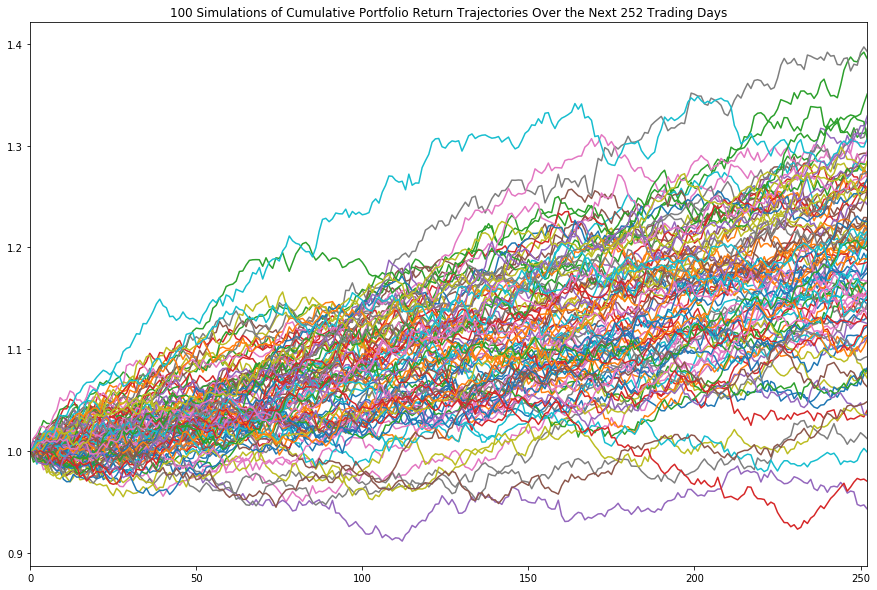

In [16]:
# Visualize the Simulation
plot_title = f"{number_simulations} Simulations of Cumulative Portfolio Return Trajectories Over the Next {number_records} Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title, figsize=(15,10))

In [17]:
# Setup the Monte Carlo Parameters (~ 30 years)
number_simulations = 500
number_records = 252 * 30

In [18]:
for x in range (number_simulations):
    simulated_spy_prices = [spy_last_price]
    simulated_agg_prices = [agg_last_price]
    for y in range (number_records):
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_returns_spy, std_dev_daily_returns_spy))
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_returns_agg, std_dev_daily_returns_agg))
        simulated_spy_prices.append(simulated_spy_price)
        simulated_agg_prices.append(simulated_agg_price)
    monte_carlo['SPY prices'] = pd.Series(simulated_spy_prices)
    monte_carlo['AGG prices'] = pd.Series(simulated_agg_prices)
    simulated_daily_returns = monte_carlo.pct_change()
    weights = [0.6, 0.4]
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    portfolio_cumulative_returns[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997747,0.998129,0.996398,0.997942,1.001856,1.001863,0.998190,1.005494,0.997545,1.005806,...,1.001765,1.013933,1.008457,0.993958,1.004440,1.001939,0.997713,1.005076,1.001060,1.000179
2,1.001008,0.997498,0.998712,0.997741,1.004319,1.002056,0.996707,1.006982,0.995040,1.007001,...,0.991221,1.018414,1.014430,0.991935,1.001995,0.996612,0.998909,1.008335,1.000325,1.000670
3,0.998947,1.002341,1.004285,0.997413,1.006286,0.999876,0.996628,1.012594,0.992629,1.009810,...,0.988939,1.012611,1.009988,0.995005,1.011347,0.998608,0.996769,1.010539,1.002136,1.000003
4,1.000508,1.015474,1.013250,1.001494,1.001636,1.003185,0.992138,1.008055,0.998453,1.009354,...,0.989647,1.012775,1.012899,0.995781,1.005764,1.004052,0.996104,1.017608,1.007160,0.997786


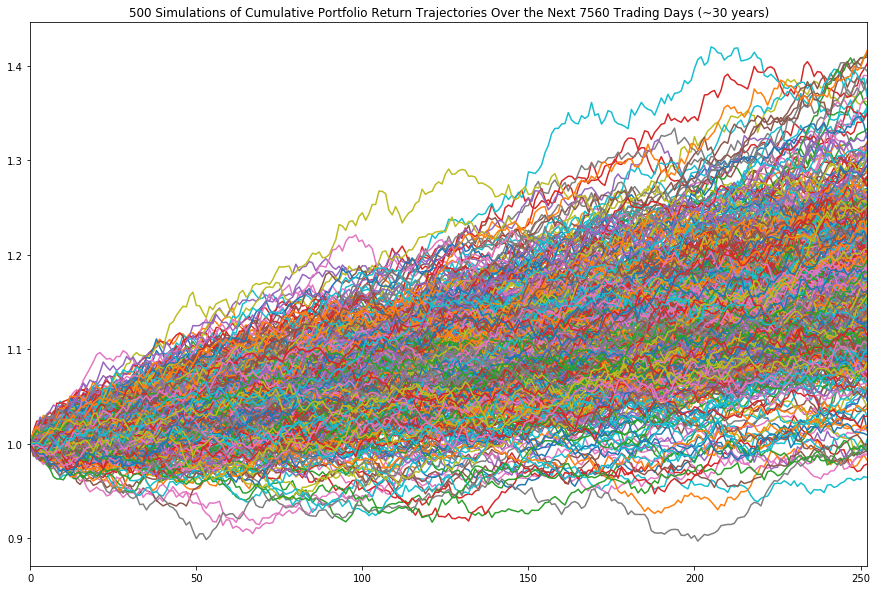

In [19]:
# Visualize the Simulation
plot_title = f"{number_simulations} Simulations of Cumulative Portfolio Return Trajectories Over the Next {number_records} Trading Days (~30 years)"
portfolio_cumulative_returns.plot(legend=None, title=plot_title, figsize=(15,10))

In [21]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    1.150683
1    1.160887
2    1.155059
3    1.350282
4    1.108830
Name: 252, dtype: float64

In [ ]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)


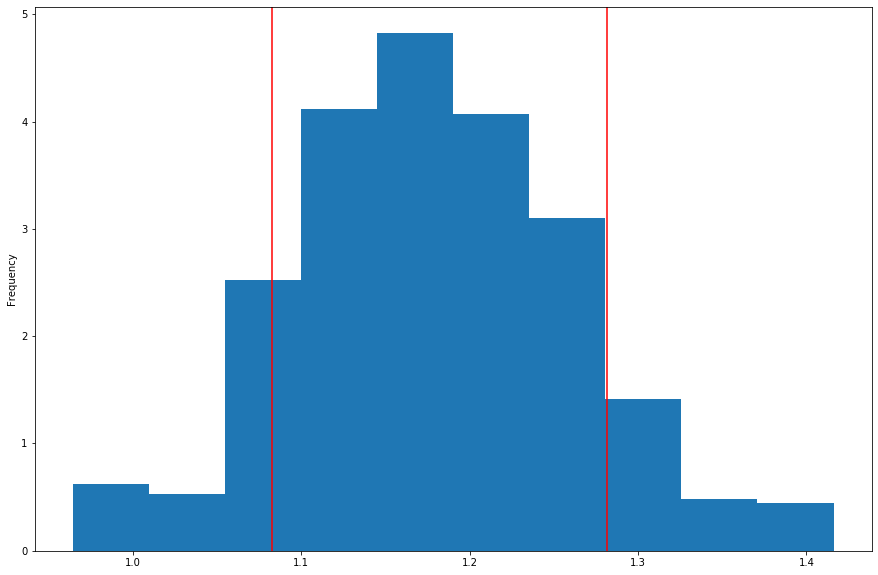

In [22]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns.quantile(q=[0.1, 0.9])
ending_cumulative_returns.plot(kind='hist', density=True, bins=10, figsize=(15,10))
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [42]:
# Visualize the distribution of the ending returns


---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [24]:
# Set Initial Investment
initial_investment = 20000

In [29]:
# New Confidence Interval
new_confidence_interval = ending_cumulative_returns.quantile(q=[0.1, 0.5, 0.9])

In [30]:
# Calculate Investment Profit/loss
tenth_percentile = initial_investment + (initial_investment * new_confidence_interval.iloc[0])
fiftieth_percentile = initial_investment + (initial_investment * new_confidence_interval.iloc[1])
ninetieth_percentile = initial_investment + (initial_investment * new_confidence_interval.iloc[2])

In [35]:
# Print the Results
print(f"""
      Expected cumulative returns at 30 years: 
      10th percentile => ${round(tenth_percentile, 2)} 
      50th percentile => ${round(fiftieth_percentile, 2)} 
      90th percentile => ${round(ninetieth_percentile, 2)}
""")


      Expected cumulative returns at 30 years: 
      10th percentile => $41657.73 
      50th percentile => $43480.71 
      90th percentile => $45636.97



### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [52]:
# Rates
yearly_rate = tenth_percentile * .04 
monthly_rate = yearly_rate / 12

### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [44]:
# Set Initial Investment
new_initial = 20000 + (20000*.5)

In [47]:
# New Confidence Interval
new_con_inter = ending_cumulative_returns.quantile(q=[0.1])

In [48]:
# Calculate Investment Profit/loss
new_tenth_percentile = new_initial + (new_initial * new_con_inter.iloc[0])

In [49]:
# Calculate the Yearly Rate
new_yearly_rate = new_tenth_percentile * .04

### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 